# Denoising with an autoencoder

Adapted from: https://towardsdatascience.com/autoencoders-and-the-denoising-feature-from-theory-to-practice-db7f7ad8fc78

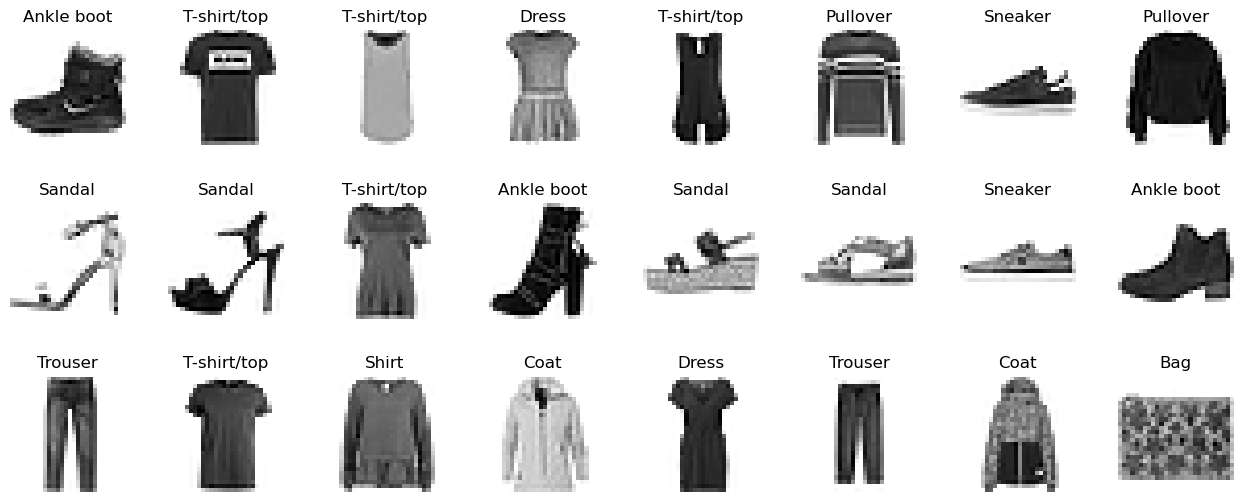

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.utils import plot_model
from keras.datasets.fashion_mnist import load_data

(X_train_full, y_train_full), (X_test, y_test) = load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:55000], X_train_full[55000:]
y_train, y_valid = y_train_full[:55000], y_train_full[55000:] 

targets = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", 
                 "Shirt", "Sneaker", "Bag", "Ankle boot"]
n_rows = 3
n_cols = 8
plt.figure(figsize=(n_cols * 2, n_rows * 2))
for row in range(n_rows):
    for col in range(n_cols)  :
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary")
        plt.axis('off')
        plt.title(targets[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [12]:
from keras.layers import Conv2D, MaxPool2D, GaussianNoise, Reshape, Conv2DTranspose

denoising_encoder = Sequential([
    Reshape([28, 28, 1], input_shape=[28, 28]),
    GaussianNoise(0.2),
    Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    MaxPool2D(pool_size=2),
    Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    MaxPool2D(pool_size=2),
    Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    MaxPool2D(pool_size=2)
])

denoising_decoder = Sequential([
    Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    Reshape([28, 28])
])

denoising_ae = Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=SGD(lr=0.5))

In [13]:
history = denoising_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.5992 - val_loss: 0.5496
Epoch 2/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.4321 - val_loss: 0.3801
Epoch 3/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.3670 - val_loss: 0.3584
Epoch 4/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.3509 - val_loss: 0.3453
Epoch 5/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.3406 - val_loss: 0.3367
Epoch 6/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.3333 - val_loss: 0.3299
Epoch 7/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.3274 - val_loss: 0.3243
Epoch 8/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.3225 - val_loss: 0.3198
Epoch 9/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.3185 - val_loss: 0.3162
Epoch 10/10
1719/1719 [==============================] - 13s 8ms/step -

While both the simple and invariant output are significantly denoised, the invariant output has a mild pixelation.

This is due to the fact that neighboring pixels are denoised using different information, leading to discontinuities in the reconstructed output.

1/1 [==============================] - 0s 51ms/step


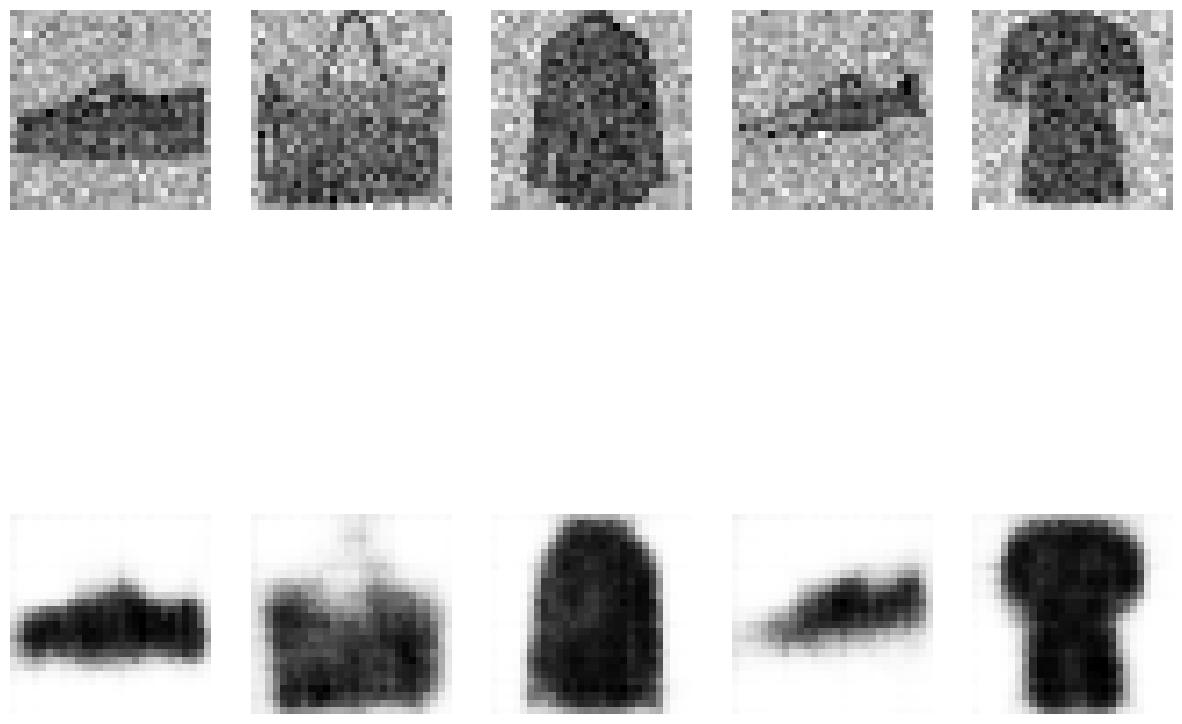

In [14]:
corrupted_inputs = GaussianNoise(0.2)(X_valid[8:13], training=True)
reconstructs = denoising_ae.predict(corrupted_inputs)
plt.figure(figsize=(15,12))
for i in range(5):
    plt.subplot(2,5,1+i)
    plt.imshow(corrupted_inputs[i], cmap='binary')
    plt.axis('off')
    plt.subplot(2,5,6+i)
    plt.imshow(reconstructs[i], cmap='binary')
    plt.axis('off')
plt.show()